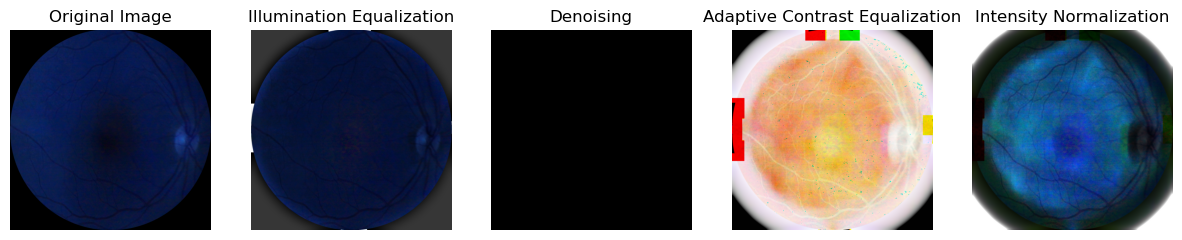

TypeError: 'AxesSubplot' object is not subscriptable

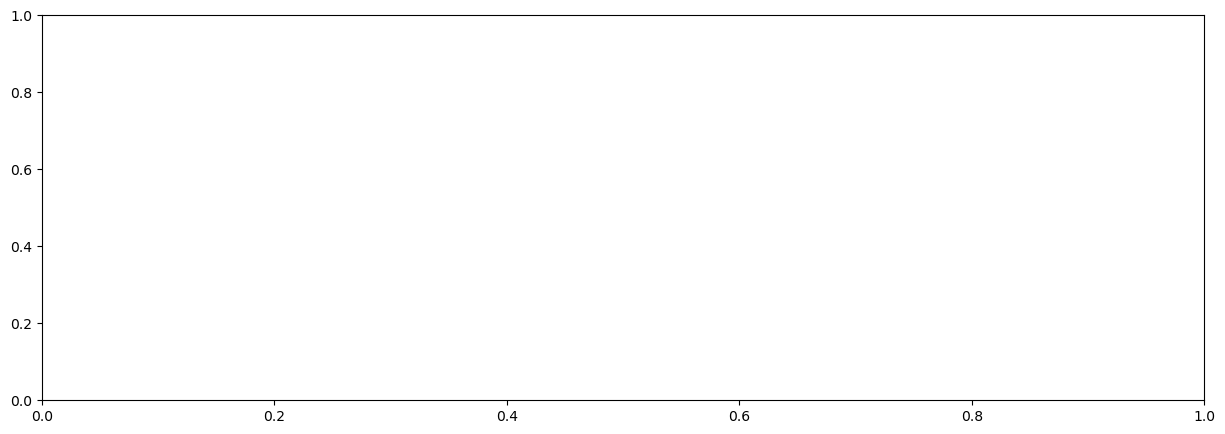

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_images(images, titles):
    n = len(images)
    _, axs = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        if len(images[i].shape) == 3 and images[i].shape[2] == 3:
            images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        axs[i].imshow(images[i], cmap='gray' if len(images[i].shape) < 3 else None)
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.show()

def normalize_image(image):
    if image.dtype != np.float32:
        image = image.astype(np.float32)
    if np.max(image) > 1.0:
        image /= 255.0
    return image

def fundus_roi(image, mask=None):
    image = normalize_image(image)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    threshold = 15 / 255.0  # Normalisé car l'image est maintenant entre 0 et 1
    _, roi = cv2.threshold(v, threshold, 1, cv2.THRESH_BINARY)
    roi = roi.astype(np.uint8)
    white_pixels = np.argwhere(roi == 1)
    if white_pixels.size == 0:
        print("Aucun pixel blanc trouvé dans le masque.")
        return {"roi": roi, "diameter": 0, "image": image}
    x_min, y_min = np.min(white_pixels, axis=0)
    x_max, y_max = np.max(white_pixels, axis=0)
    diameter_x = x_max - x_min
    diameter_y = y_max - y_min
    diameter = int(np.maximum(diameter_x, diameter_y))
    return {"roi": roi, "diameter": diameter, "image": image}

def mean_filter(channel, kernel_size):
    kernel_size = int(kernel_size)
    if kernel_size % 2 == 0:
        kernel_size += 1
    filtered_channel = cv2.blur(channel, (kernel_size, kernel_size))
    return filtered_channel

def illumination_equalization(image, diameter=None, roi=None):
    image = normalize_image(image)
    if diameter is None:
        print('Erreur: Le diamètre est None. Impossible de continuer.')
        return None
    kernel_size = int(diameter / 10)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    v_filtered = mean_filter(v, kernel_size)
    mean_v = np.mean(v)
    v_final = cv2.addWeighted(v, 1, v_filtered, -1, mean_v)
    hsv_final = cv2.merge([h, s, v_final])
    image_final = cv2.cvtColor(hsv_final, cv2.COLOR_HSV2BGR)
    return {"image": normalize_image(image_final), "diameter": diameter}

def denoising(image, diameter=None, roi=None):
    image = normalize_image(image)
    if diameter is None:
        print('Erreur: Le diamètre est None dans denoising. Impossible de continuer.')
        return None
    kernel_size = int(diameter / 360)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    v_filtered = mean_filter(v, kernel_size)
    hsv_denoised = cv2.merge([h, s, v_filtered])
    denoising_image = cv2.cvtColor(hsv_denoised, cv2.COLOR_HSV2BGR)
    return {"image": normalize_image(denoising_image), "diameter": diameter}

def adaptive_contrast_equalization(image, diameter=None):
    # Normalisation de l'image (si nécessaire)
    # image = normalize_image(image)
    
    if diameter is None:
        print('Erreur: Le diamètre est None dans adaptive_contrast_equalization. Impossible de continuer.')
        return None
    
    d1 = diameter / 10
    image_float = image.astype(np.float32)
    E_x = mean_filter(image_float, d1)
    E_x2 = mean_filter(image_float ** 2, d1)
    var = E_x2 - E_x ** 2
    var[var < 0] = 0
    std = np.sqrt(var)
    high_pass_filter = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]) / 9.0
    convolution = cv2.filter2D(image_float, -1, 1 - high_pass_filter)
    # Gestion des NaN
    epsilon = 1e-7
    image_final = image_float + (1.0 / (epsilon + std)) * convolution
    image_final = np.clip(image_final, 0, 255)
    image_final = image_final.astype(np.uint8)
    
    return {"image": image_final}

def mean_filter(image, diameter):
    kernel_size = int(diameter)
    if kernel_size % 2 == 0:
        kernel_size += 1
    return cv2.blur(image, (kernel_size, kernel_size))


def apply_intensity_normalization(image, diameter=None, roi=None):
    image = normalize_image(image)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    v_normalized = cv2.normalize(v, None, 0, 1, cv2.NORM_MINMAX)
    hsv_normalized = cv2.merge([h, s, v_normalized])
    image_final = cv2.cvtColor(hsv_normalized, cv2.COLOR_HSV2BGR)
    return {"image": normalize_image(image_final)}

def apply_seoud(image):
    images = []
    titles = []

    data = fundus_roi(image)
    images.append(cv2.cvtColor((data["image"] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    titles.append("Original Image")
    
    illumination = illumination_equalization(**data)
    if illumination is None:
        print('Erreur lors de l\'égalisation de l\'illumination.')
        return None
    images.append(cv2.cvtColor((illumination["image"] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    titles.append("Illumination Equalization")

    denoise = denoising(**illumination)
    if denoise is None:
        print('Erreur lors de la réduction de bruit.')
        return None
    images.append(cv2.cvtColor((denoise["image"] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    titles.append("Denoising")

    contrast = adaptive_contrast_equalization(**denoise)
    images.append(cv2.cvtColor((contrast["image"] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    titles.append("Adaptive Contrast Equalization")

    normalized_image = apply_intensity_normalization(**contrast)
    images.append(cv2.cvtColor((normalized_image["image"] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    titles.append("Intensity Normalization")

    plot_images(images, titles)
    return normalized_image["image"]

# Chargement de l'image
image = cv2.imread('../data/image_1.png')
if image is None:
    print("Erreur: Impossible de charger l'image.")
else:
    seoud_image = apply_seoud(image)
    if seoud_image is not None:
        plot_images([cv2.cvtColor((seoud_image * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)], ['Final Preprocessed Image'])
